In [1]:
import os.path as osp
import argparse
import glob
import random
from tqdm import tqdm, trange

import torch
import pandas as pd
import numpy as np
from deepsnap.batch import Batch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import cm
import matplotlib.pyplot as plt

import umap
import umap.plot
import hdbscan

from codescholar.representation.train import train_loop
from codescholar.representation import models, config, dataset
from codescholar.utils.train_utils import build_model, featurize_graph
from codescholar.utils.graph_utils import program_graph_to_nx

from codescholar.sast.simplified_ast import get_simplified_ast
from codescholar.sast.visualizer import render_sast

In [2]:
parser = argparse.ArgumentParser()
config.init_optimizer_configs(parser)
config.init_encoder_configs(parser)
args, unknown = parser.parse_known_args()
args.test = True

args.n_test = 128000

In [3]:
model = build_model(models.SubgraphEmbedder, args)

In [4]:
def get_source(file):
    with open(file, 'r') as fp: 
        source = fp.read()
    
    return source

def get_emb_from_datapoint(datapoint):
    return model.encoder(Batch.from_data_list([datapoint]))

## DeepSnap Datapoint 2 Embedding

In [8]:
idx = 1
processed_dir = "./tmp/pandas/test/processed/"
data = torch.load(osp.join(processed_dir, f'data_{idx}.pt'))
example = data[0]

print(example.span)
emb = get_emb_from_datapoint(example)

['np', '#[#]', '#.dtype', '# = #', '#(#)']


## NetworkX Graph 2 Embedding

In [6]:
idx = 3
graphs_dir = "./tmp/pandas/test/graphs/"
graph = torch.load(osp.join(graphs_dir, f'data_{idx}.pt'))
example = featurize_graph(graph, 0)

print(example.span)
emb = get_emb_from_datapoint(example)

['#', 'def solv#n_analy#ults(#', 'return #', '#(#)', 'self', '#()', '#(#, #, #)', '#.fixture', 'scope=#', '#.setup', '#.run', 'start=#', 'stop=#', 'step=#', 'pytest', "'class'", 'self', '#(#, #, #)', '0', '4', '1', 'SolvationAnalysis', '#.solute', '#.solvent', '[#, #]', 'self', 'self', '2', '10']


## Source 2 Embedding

In [7]:
idx = '800_3'
raw_dir = "./tmp/pandas/test/raw/"

source = get_source(osp.join(raw_dir, f'example{idx}.py'))
prog_graph = get_simplified_ast(source, dfg=False, cfg=False)
graph = program_graph_to_nx(prog_graph, directed=True)
example = featurize_graph(graph, 0)

print(example.span)
emb = get_emb_from_datapoint(example)

removinggg
['#', 'def solvation_analysis_list_results(#): # #', 'return #', 'self', '#()', '#(#, #, #)', '#.setup', '#.run', 'start=#', 'stop=#', 'step=#', 'self', '#(#, #, #)', '0', '4', '1', 'SolvationAnalysis', '#.solute', '#.solvent', '[#, #]', 'self', 'self', '2', '10']


## Experiment: Clustering Graph Embeddings

In [8]:
sample_size = 100

# use source files
graph_files = sorted(glob.glob(osp.join(graphs_dir, '*.pt')))
indices = random.choices(range(len(graph_files)), k=sample_size)
examples = []

for idx in tqdm(indices):
    graph = torch.load(graph_files[idx])
    examples.append(featurize_graph(graph, 0))

100%|█████████████████████████████████████████| 100/100 [07:39<00:00,  4.60s/it]


In [9]:
embeddings = model.encoder(Batch.from_data_list(examples)).detach().numpy()

### UMAP + HDBSCAN

In [10]:
# Ref: https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e

def generate_clusters(embeddings, n_neighbors, n_components, 
                      min_cluster_size, random_state = None):
    """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
    """
    
    umap_embeddings = (umap.UMAP(n_neighbors=n_neighbors, 
                                n_components=n_components, 
                                metric='cosine', 
                                random_state=random_state)
                            .fit_transform(embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='euclidean', 
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters

def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given cluster supplied from running hdbscan
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

def random_search(embeddings, space, num_evals, random_state=42):
    """
    Randomly search hyperparameter space a limited number of times 
    and return a summary of the results
    """
    
    results = []
    
    for i in trange(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        
        clusters = generate_clusters(embeddings, n_neighbors = n_neighbors, 
                                     n_components = 2, 
                                     min_cluster_size = min_cluster_size, 
                                     random_state = random_state)
    
        label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
                
        results.append([i, n_neighbors, 2, min_cluster_size, 
                        label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components', 
                                               'min_cluster_size', 'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

In [11]:
# hyperparameter tuning

space = {
    "n_neighbors": range(5, 10),
    "min_cluster_size": range(2, 10),
}

hyperparameters = random_search(embeddings, space, 100, random_state=42)

100%|█████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]


In [57]:
hyperparameters[:20]

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
39,39,5,2,9,2,0.00
63,63,5,2,5,2,0.00
30,30,5,2,9,2,0.00
44,44,5,2,5,2,0.00
20,20,5,2,5,2,0.00
50,50,5,2,8,2,0.00
70,70,7,2,8,4,0.02
90,90,7,2,8,4,0.02
27,27,7,2,8,4,0.02
96,96,7,2,8,4,0.02


#### Using the best hyperparameters

In [92]:
mapper = umap.UMAP(n_neighbors=5, n_components=2, metric='cosine', random_state=42).fit(embeddings)

umap_embeddings = mapper.transform(embeddings)

clusters = hdbscan.HDBSCAN(min_cluster_size=4, metric='euclidean',
                           cluster_selection_method='eom').fit(umap_embeddings)

<AxesSubplot: >

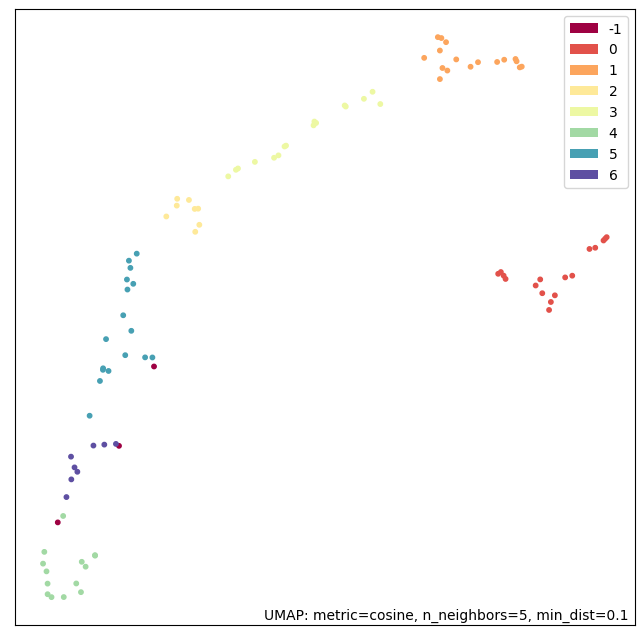

In [93]:
umap.plot.points(mapper, labels=clusters.labels_)

In [94]:
def print_cluster_progs(files, labels, cluster_id):
    sources = []
    for file, label in zip(files, labels):
        if label == cluster_id:
            source = get_source(file)
            sources.append(source)
            print("----------")
            print("FILE:", file)
            print(source)
            print("----------\n")
    
    return sources

In [96]:
raw_files = sorted(glob.glob(osp.join(raw_dir, '*.py')))
chosen_files = [file for idx, file in enumerate(raw_files) if idx in indices]

progs = print_cluster_progs(chosen_files, clusters.labels_, cluster_id=1)

----------
FILE: ./tmp/pandas/test/raw/example810_20.py


def test_fy5253_last_onoffset():
    offset = FY5253(n=(- 5), startingMonth=5, variation='last', weekday=0)
    ts = Timestamp('1984-05-28 06:29:43.955911354+0200', tz='Europe/San_Marino')
    fast = offset.is_on_offset(ts)
    slow = (((ts + offset) - offset) == ts)
    assert (fast == slow)

----------

----------
FILE: ./tmp/pandas/test/raw/example812_0.py


def add_sidebar_select_channels():
    st.sidebar.title('Select channel(s)')
    st.sidebar.markdown('You can select one or several YouTube channels. If you select none, all channels will be use.')
    if (not isinstance(st.session_state.df_scores, pd.DataFrame)):
        st.sidebar.warning(MSG_NO_DATA)
        return
    df = st.session_state.df_scores
    all_uploaders = df['uploader'].unique()
    selected_uploaders = st.sidebar.multiselect('', all_uploaders)
    if len(selected_uploaders):
        df = df[df['uploader'].isin(selected_uploaders)]
    st.session_state.d